<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">
# 05 - Reciprocal `BLAST` Hits (RBH)

## Table of Contents

1. [Introduction](#introduction)
2. [Python imports](#imports)
3. [Pairwise Reciprocal Best `BLAST` Hits](#rbbh)
  1. [Using local `BLAST` for RBH analysis](#rbbh_code)
  2. [Loading BLAST results](#load)
  3. [Normalised bit score](#bitscore)
  4. [Visualising one-way match results](#oneway)
  5. [Identifying reciprocal best matches](#reciprocal)
  6, [Visualising RBH results](#visualise_rbh)
4. [RBH For Multiple Gene Sets](#multiple)

## Introduction

This notebook presents an example of programmatic use of `BLAST` to solve a biological problem: which gene features in a set of organisms are likely to be *orthologues*.

The term *orthologue* originally applied to features that derived from a common ancestor, and diverged through speciation. Where an unambiguous sequence counterpart can be identified in each of two diverged organisms, this may be taken to imply that the sequences are *orthologues*.  

![orthologues diverge by speciation](images/05-01_orthologues.png)

<div class="alert-warning">
An assumption can be made that the function carried out by that feature was important in the ancestor, and is also important in its descendents (that is why the feature is retained). It can also be assumed that the function of that feature is broadly conserved, and that is why the feature is retained (this is known as "The Orthologue Conjecture").
</div>

Biology is rarely that simple, however. In reality, gene duplication and gene transfer events complicate the picture. Gene duplication results in two copies of a gene being made, theoretically allowing the function of one to diverge. This may occur multiple times, and any (or no) copies may be retained. Alternatively, gene transfer from one organism to another may displace the inherited gene, or make it appear as though a gene was acquired through inheritance when it was not.

![paralogues diverge by duplication](images/05-02_paralogues.png)

Despite these and other complication, the identification of *reciprocal best hits* for gene products is a good first approximation to the identification of *orthologues* in two or more organisms. It forms the basis for many orthology-finding tools, such as `MCL`, `OrthoMCL` and `OrthoFinder`. It can be carried out by carrying out `BLAST+` searches using a short program, and this will be illustrated below.

Differences in the composition of gene complements (e.g. presence/absence of *orthologues*) my support hypotheses for functional or phenotypic differences, and identify characteristic signals for diagnostics and epidemiology. In an industrial biotechnology context, they can be used to identify common "parts lists" that allow the construction of "wiring diagrams" that can be exploited by systems and synthetic biology.

<a id="imports"></a>
## Python imports

To interact with the local installation of `BLAST`, we will use the free `Biopython` programming tools. These provide an interface to interact with `BLAST`, run jobs, and to read in the output files.

To collate the `BLAST` search results as dataframes/tables for analysis, we will use the `pandas` package.

To graph the downstream results, we will use the `seaborn` visualisation package.

We import these tools, and some standard library packages for working with files (`os`) below.

In [1]:
# Show plots as part of the notebook
%pylab inline

# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastpCommandline

# Colour scale transformation
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


<a id="rbbh"></a>
## Reciprocal Best `BLAST` Hits

A procedure for identifying reciprocal best hits between the protein complements of two organisms proceeds as follows:

#### Identify protein sets
* Take all the protein sequences from organism 1, and call this $S_1$
* Take all the protein sequences from organism 2, and call this $S_2$

#### Conduct `BLAST` search
* Use `BLAST+` to query the proteins from $S_1$ against those in $S_2$. These are the *forward results*.
* Use `BLAST+` to query the proteins from $S_2$ against those in $S_1$. These are the *reverse results*.

#### Identify forward best hits
* Consider each query sequence from $S_1$ in turn, and from the *forward results* identify the 'best match' in $S_2$.
* Make a table associating each sequence from $S_1$ with its best match in $S_2$. These are the *forward best hits*

#### Identify reverse best hits
* Consider each query sequence from $S_2$ in turn, and from the *reverse results* identify the 'best match' in $S_1$.
* Make a table associating each sequence from $S_2$ with its best match in $S_1$. These are the *reverse best hits*

#### Identify RBH
* Consider each query sequence (call this $p_1$) from $S_1$ in turn, and from the *forward best hits* table identify its 'best match' in $S_2$ (call this $p_2$).
* Check the *reverse best hits table* to find the 'best match' in the reverse direction for $p_2$.
* **If this 'best match' is $p_1$, then $p_1$ and $p_2$ are *reciprocal best matches*. **

We will write code to do this analysis in the cells below.

<a id="rbbh_code"></a>
### Using local `BLAST` for pairwise RBH analysis

You need firstly to identify our two input protein sets: these are FASTA format multiple sequence files describing protein sets from two *Kitasatospora* isolates:

* `data/kitasatospora/GCA_001424875.1_Root107_protein.faa`
* `data/kitasatospora/GCA_001429805.1_Root187_protein.faa`

and, as you did in [notebook 03](03-programming_for_blast.ipynb), construct and execute a local `BLASTP` search of each protein set against the other. For ease of processing, you will obtain `BLAST` results in tabular format.

In [2]:
# Define input and output directories
datadir = os.path.join('data', 'kitasatospora')
outdir = os.path.join('output', 'kitasatospora')
os.makedirs(outdir, exist_ok=True)

# Define input file paths
s1 = os.path.join(datadir, 'GCA_001424875.1_Root107_protein.faa')
s2 = os.path.join(datadir, 'GCA_001429805.1_Root187_protein.faa')

# Define output BLAST results
fwd_out = os.path.join(outdir, '05-fwd-results.tab')
rev_out = os.path.join(outdir, '05-rev-results.tab')

<div class="alert-success">
<b>`BLASTP` allows the definition of `-query` and `-subject` sequence sets, so you don't have to build a database every time. However database searches are, in general, much faster</b>
</div>

We can use two features of command-line `BLAST` that make our job easier later.

* We will restrict the number of matches to be returned to 1, by using the `-max_target_seqs` argument. This will only report the best hit for each query.
* We will ask only for specific information in the returned results, using the `-outfmt` argument to recover: query ID, subject ID, percentage identity, percentage coverage, alignment score, and alignment E-value. (See the `blastp -help` output for more information on these options).

In [3]:
# Create BLAST command-lines for forward and reverse BLAST searches
fwd_blastp = NcbiblastpCommandline(query=s1, subject=s2, out=fwd_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)
rev_blastp = NcbiblastpCommandline(query=s2, subject=s1, out=rev_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)

# Inspect command-lines
print("FORWARD: %s" % fwd_blastp)
print("REVERSE: %s" % rev_blastp)

FORWARD: blastp -out output/kitasatospora/05-fwd-results.tab -outfmt '6 qseqid sseqid pident qcovs qlen slen length bitscore evalue' -query data/kitasatospora/GCA_001424875.1_Root107_protein.faa -max_target_seqs 1 -subject data/kitasatospora/GCA_001429805.1_Root187_protein.faa
REVERSE: blastp -out output/kitasatospora/05-rev-results.tab -outfmt '6 qseqid sseqid pident qcovs qlen slen length bitscore evalue' -query data/kitasatospora/GCA_001429805.1_Root187_protein.faa -max_target_seqs 1 -subject data/kitasatospora/GCA_001424875.1_Root107_protein.faa


<div class="alert-danger">
<b>The cell below will execute two large local `BLASTP` searches. This can cause quite a delay in the lesson as the searches are carried out, so the results have been precalculated and are provided in another location. The rest of the lesson can progress using these pre-calculated results</b>

In [4]:
# THIS CELL RUNS LARGE LOCAL BLAST SEARCHES
# IT IS SKIPPED BY DEFAULT

# Run BLAST searches
# !! Uncomment to run local BLAST searches !!
#fwd_stdout, fwd_stderr = fwd_blastp()
#rev_stdout, rev_stderr = rev_blastp()

# Check STDOUT, STDERR
#print("FWD STDOUT: %s" % fwd_stdout)
#print("FWD STDERR: %s" % fwd_stderr)
#print("REV STDOUT: %s" % rev_stdout)
#print("REV STDERR: %s" % rev_stderr)

<a id="load"></a>
### Loading `BLAST` results

Once the `BLAST` searches are finished, you can load the tabular format results into two `pandas` dataframes, so that the output can be modified and inspected.

The `BLAST` output does not come with column headers in the file, so we have to add these ourselves, to match the columns requested in the original `BLAST` query.

<div class="alert-danger">
<b>The cell below loads in pre-calculated results, to save lesson time. To use results calculated by the cell above, comment out the lines defining `fwd_out` and `rev_out`.
</div>

In [5]:
# PRECALCULATED BLAST RESULTS
# COMMENT OUT THESE LINES IF YOU WANT TO USE THE RESULTS FROM THE CELL ABOVE
fwd_out = os.path.join('prepped', 'kitasatospora', '05-fwd-results.tab')
rev_out = os.path.join('prepped', 'kitasatospora', '05-rev-results.tab')

# Load the BLAST results into Pandas dataframes
fwd_results = pd.read_csv(fwd_out, sep="\t", header=None)
rev_results = pd.read_csv(rev_out, sep="\t", header=None)

# Add headers to forward and reverse results dataframes
headers = ["query", "subject", "identity", "coverage",
           "qlength", "slength", "alength",
           "bitscore", "E-value"]
fwd_results.columns = headers
rev_results.columns = headers

<a id="bitscore"></a>
### Normalised bit score, and coverage

<div class="alert-success">
<b>Before you examine the `BLAST` results themselves, it is useful to define a new quantity: the <i>normalised bitscore</i>.
</div>

The bitscore reported by `BLAST` is the sum of the qualities of the aligned symbols over the whole alignment. This is an accurate measure of the alignment strength, but long sequences tend to have higher bitscores than short sequences, even when the matches are of about the same quality. To correct for this length effect, we can calculate a *normalised bitscore* where:

$$\textrm{normalised bitscore} = \frac{\textrm{bitscore}}{\textrm{query length}}$$

This makes comparisons of bitscore between proteins of different lengths a bit more fair.

#### Calculations using `pandas` columns

Rather than looping over every item in a `pandas` dataframe column, it is possible to carry out calculations on entire columns in one action. So, to divide the contents of the `bitscore` column by the contents of the `qlength` column in the `fwd_results` dataframe, on a row-by-row basis, we can use the Python code:

```
fwd_results.bitscore/fwd_results.qlength
```

<div class="alert-success">
<b>You will find it useful to consider two types of <i>coverage</i>: query coverage and alignment coverage.
</div>

The query and subject sequences in a `BLAST` alignment may not be of the same length, so it is possible that an alignment that covers the whole of one of the sequences may only cover a small part of the other sequence (e.g. if the query sequence is a single domain protein, and that domain is part of a multi-domain protein subject sequence). We can define two more columns in the dataframe:

$$\textrm{query coverage} = \frac{\textrm{alignment length}}{\textrm{query length}}$$
$$\textrm{subject coverage} = \frac{\textrm{alignment length}}{\textrm{subject length}}$$


In [6]:
# Create a new column in both dataframes: normalised bitscore
fwd_results['norm_bitscore'] = fwd_results.bitscore/fwd_results.qlength
rev_results['norm_bitscore'] = rev_results.bitscore/rev_results.qlength

# Create query and subject coverage columns in both dataframes
fwd_results['qcov'] = fwd_results.alength/fwd_results.qlength
rev_results['qcov'] = rev_results.alength/rev_results.qlength
fwd_results['scov'] = fwd_results.alength/fwd_results.slength
rev_results['scov'] = rev_results.alength/rev_results.slength

# Clip maximum coverage values at 1.0
fwd_results['qcov'] = fwd_results['qcov'].clip_upper(1)
rev_results['qcov'] = rev_results['qcov'].clip_upper(1)
fwd_results['scov'] = fwd_results['scov'].clip_upper(1)
rev_results['scov'] = rev_results['scov'].clip_upper(1)

In [7]:
# Inspect the forward results data
fwd_results.head()

,query,subject,identity,coverage,qlength,slength,alength,bitscore,E-value,norm_bitscore,qcov,scov
0,KQV03227.1,KRB66190.1,100.0,100,567,567,567,1134.0,0.000000e+00,2.000000,1.0,1.0
1,KQV03228.1,KRB66189.1,100.0,100,98,98,98,193.0,6.800000e-67,1.969388,1.0,1.0
2,KQV03229.1,KRB66188.1,100.0,100,252,252,252,470.0,2.760000e-171,1.865079,1.0,1.0
3,KQV03230.1,KRB66187.1,100.0,100,337,337,337,670.0,0.000000e+00,1.988131,1.0,1.0
4,KQV03231.1,KRB66186.1,100.0,100,143,143,143,274.0,1.530000e-97,1.916084,1.0,1.0


In [8]:
# Inspect the reverse results data
rev_results.head()

,query,subject,identity,coverage,qlength,slength,alength,bitscore,E-value,norm_bitscore,qcov,scov
0,KRB60369.1,KQV20977.1,100.0,100,324,324,324,640.0,0.000000e+00,1.975309,1.0,1.0
1,KRB60370.1,KQV20976.1,100.0,100,244,244,244,488.0,1.110000e-178,2.000000,1.0,1.0
2,KRB60371.1,KQV20975.1,100.0,100,102,102,102,203.0,1.210000e-70,1.990196,1.0,1.0
3,KRB60372.1,KQV20974.1,100.0,100,103,103,103,213.0,1.140000e-74,2.067961,1.0,1.0
4,KRB60373.1,KQV20973.1,100.0,100,299,299,299,595.0,0.000000e+00,1.989967,1.0,1.0


<a id="oneway"></a>
### Visualising one-way match results

Each result dataframe contains one row per query sequence, showing the best match, and some properties of the sequence alignment.

Using the `seaborn` package, you can summarise elements of this data visually, to get some insight into an organism-vs-organism `BLAST` search. For instance, a single line of code can produce a distribution plot (kernel density estimate, and histogram) of the `bitscore` for each `BLAST` hit. The bitscore encapsulates the *quality* of the match, and is a single measure that reflects the number of similar residues in the alignment, and their similarity.

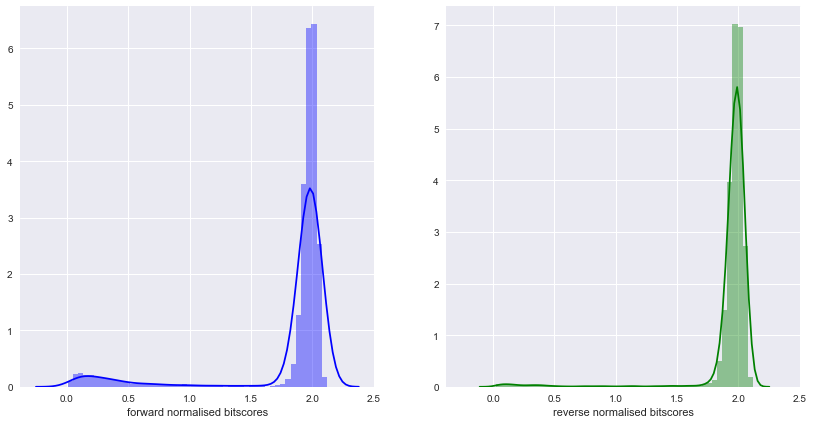

In [9]:
# Set up the figure
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
sns.despine(left=True)

# Plot distribution of forward and reverse hit bitscores
sns.distplot(fwd_results.norm_bitscore, color="b", ax=axes[0], axlabel="forward normalised bitscores")
sns.distplot(rev_results.norm_bitscore, color="g", ax=axes[1], axlabel="reverse normalised bitscores");

The two plots that result from this code show the distributions of the *one-way* best hit `BLAST` bitscores.

The first thing you have probably noticed is that the distributions are *bimodal*: most hits lie in the main bulk of the distribution, but in both the forward and reverse searches there is a relatively small set of matches that have a low bitscore. These are likely to be low-quality matches that are either very short, sequence-dissimilar, or both.

A second plot that is useful for interpretation is the heatmap/2D density plot of query sequence coverage and subject sequence coverage:

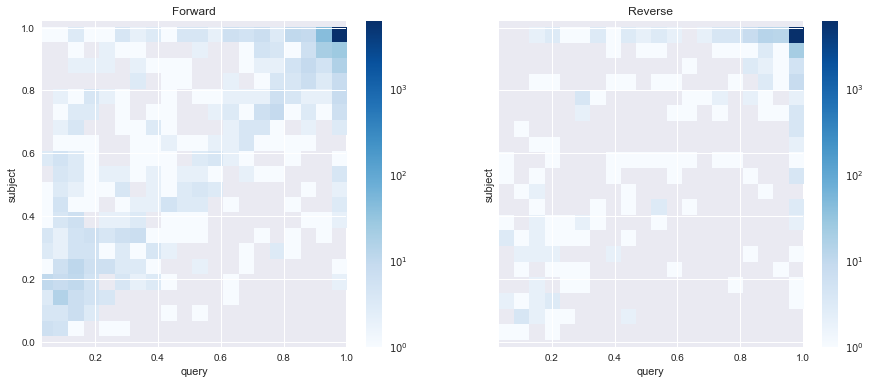

In [10]:
# Plot 2D density histograms
# !! YOU DO NOT NEED TO UNDERSTAND THIS CODE TO FOLLOW THE LESSON !!

# Calculate 2D density histograms for counts of matches at several coverage levels
(Hfwd, xedgesf, yedgesf) = histogram2d(fwd_results.qcov, fwd_results.scov, bins=20)
(Hrev, xedgesr, yedgesr) = histogram2d(rev_results.qcov, rev_results.scov, bins=20)

# Create a 1x2 figure array
fig, axes = subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Plot histogram for forward matches
im = axes[0].imshow(Hfwd, cmap=cm.Blues, norm=LogNorm(),
                    extent=[xedgesf[0], xedgesf[-1], yedgesf[0], yedgesf[-1]],
                    origin='lower', aspect=1)
axes[0].set_title("Forward")
axes[0].set_xlabel("query")
axes[0].set_ylabel("subject")

# Plot histogram for reverse matches
im = axes[1].imshow(Hrev, cmap=cm.Blues, norm=LogNorm(),
                    extent=[xedgesr[0], xedgesr[-1], yedgesr[0], yedgesr[-1]],
                    origin='lower', aspect=1)
axes[1].set_title("Reverse")
axes[1].set_xlabel("query")
axes[1].set_ylabel("subject")

# Add colourbars
fig.colorbar(im, ax=axes[0])
fig.colorbar(im, ax=axes[1]);

<div class="alert-success">
<b>The important information from the 2D density plots is:</b>
</div>

* Most one-way matches for this data are at 100% query coverage and 100% subject coverage
* The remaining matches can be classified as either 'on the diagonal' or 'off the diagonal'
  * Hits 'on the diagonal' have approximately the same coverage in query and subject sequences: these are likely diverged proteins
  * Hits 'off the diagonal' have more coverage in either the query or subject sequence: these may be single-domain matches, poor alignments, or some other result that is unlikely to be a very good match.

It is unlikely that off-diagonal hits are one-to-one matches between orthologues.

<a id="reciprocal"></a>
### Identifying reciprocal best matches

There is more than one way to programmatically identify reciprocal best matches. In this lesson, you will use the dataframe structure to help you. The logic of this is as follows:

* For each query sequence named in `fwd_results.query`, there is a single subject sequence named in the `fwd_results.subject` column (though there may be several rows, reflecting multiple alignments between the same subject and query).
* The two dataframes `fwd_results` and `rev_results` are merged such that rows are combined when `fwd_results.subject` is the same as `rev_results.query`. This produces a new dataframe called `rbbh`, where the *forward results* query and subject columns are renamed `query_x` and `subject_x`, while the *reverse results* query and subject columns are renamed `query_y` and `subject_y`.
* Reciprocal best hits are then those where the value in `query_x` matches the value in `subject_y`.
* All rows where `query_x` does not match `subject_y` are not reciprocal best hits, so these are discarded.
* All rows containing duplicate hits between the same query and subject sequences are grouped into a single row, taking the largest value for each column in that group.

This leaves us with a single dataframe describing the reciprocal best hits for these two gene sets.

In [11]:
# Merge forward and reverse results
rbbh = pd.merge(fwd_results, rev_results[['query', 'subject']],
                left_on='subject', right_on='query',
                how='outer')

# Discard rows that are not RBH
rbbh = rbbh.loc[rbbh.query_x == rbbh.subject_y]

# Group duplicate RBH rows, taking the maximum value in each column
rbbh = rbbh.groupby(['query_x', 'subject_x']).max()

In [12]:
# Inspect the results
rbbh.head()

,,identity,coverage,qlength,slength,alength,bitscore,E-value,norm_bitscore,qcov,scov,query_y,subject_y
query_x,subject_x,,,,,,,,,,,,
KQV03227.1,KRB66190.1,100.0,100.0,567.0,567.0,567.0,1134.0,0.000000e+00,2.000000,1.0,1.0,KRB66190.1,KQV03227.1
KQV03228.1,KRB66189.1,100.0,100.0,98.0,98.0,98.0,193.0,6.800000e-67,1.969388,1.0,1.0,KRB66189.1,KQV03228.1
KQV03229.1,KRB66188.1,100.0,100.0,252.0,252.0,252.0,470.0,2.760000e-171,1.865079,1.0,1.0,KRB66188.1,KQV03229.1
KQV03230.1,KRB66187.1,100.0,100.0,337.0,337.0,337.0,670.0,0.000000e+00,1.988131,1.0,1.0,KRB66187.1,KQV03230.1
KQV03231.1,KRB66186.1,100.0,100.0,143.0,143.0,143.0,274.0,1.530000e-97,1.916084,1.0,1.0,KRB66186.1,KQV03231.1


<a id="visualise_rbh"></a>
### Visualising RBH results

Now that we have RBH results, we can produce similar visualisations to those we used for the one-way hits, to see what has changed.

First, we produce a distribution plot of the normalised bitscores:

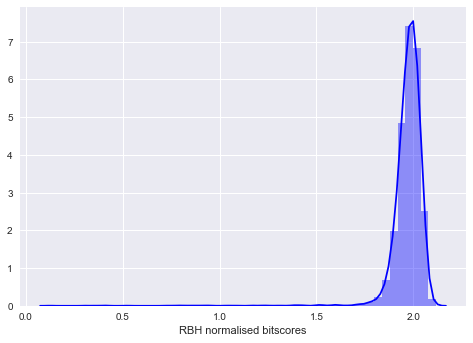

In [13]:
# Plot distribution of RBH bitscores
sns.distplot(rbbh.norm_bitscore, color="b", axlabel="RBH normalised bitscores");

From this plot we can see that the distribution is now unimodal: the matches with low normalised bitscores have disappeared. Taking reciprocal best matches has filtered out nearly all the low-quality hits.

What does the 2D distribution of coverage look like? We can plot this, as before:

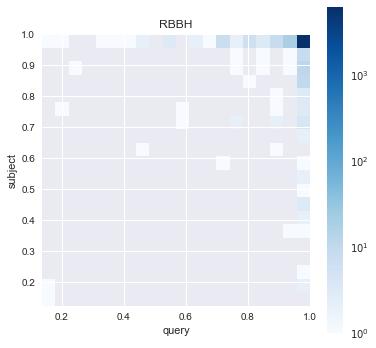

In [14]:
# Plot 2D density histograms
# !! YOU DO NOT NEED TO UNDERSTAND THIS CODE TO FOLLOW THE LESSON !!

# Calculate 2D density histograms for counts of matches at several coverage levels
(H, xedges, yedges) = histogram2d(rbbh.qcov, rbbh.scov, bins=20)

# Create a 1x2 figure array
fig, ax = subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)

# Plot histogram for RBBH
im = ax.imshow(H, cmap=cm.Blues, norm=LogNorm(),
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                 origin='lower', aspect=1)
ax.set_title("RBBH")
ax.set_xlabel("query")
ax.set_ylabel("subject")

# Add colourbar
fig.colorbar(im, ax=ax);

The difference here is even more striking. Almost all the matches along the diagonal, and off the diagonal, have disappeared. Taking reciprocal best matches has restricted the comparison between the two gene sets almost completely to proteins that are similar across almost their entire length. These are likely to be a good starting point for further analysis and transfer of functional annotation.

<p></p>
<div class="alert-success">
<b>Using reciprocal best hits as a filter, it is possible to discard a large number of low-quality alignments and improve your confidence in having found matches to sequences that are likely to be equivalent (in some way).</b>
</div>

<a id="multiple"></a>
## RBH For Multiple Gene Sets

So far you have looked at a single RBH analysis between the gene complements of a pair of genomes. You may however want to conduct this kind of analysis on several genomes.

In the cell below, we define five protein sequence files. If we want to conduct RBH analysis on these protein sequence sets, we need to perform `BLAST` searches using each of the five sequence sets as a query, against each of the other four sequence sets. This would be tedious to do by hand - especially for larger numbers of input files, so we can make the computer do all the hard work for us.

In [15]:
# Define input protein sequence files
infiles = ['GCA_000269985.1_ASM26998v1_protein.faa',
           'GCA_000696185.1_ASM69618v1_protein.faa',
           'GCA_000836635.1_ASM83663v1_protein.faa',
           'GCA_001424875.1_Root107_protein.faa',
           'GCA_001429805.1_Root187_protein.faa']

# Add the data directory to each of the input sequence files
infiles = [os.path.join(datadir, fname) for fname in infiles]
print(infiles)

['data/kitasatospora/GCA_000269985.1_ASM26998v1_protein.faa', 'data/kitasatospora/GCA_000696185.1_ASM69618v1_protein.faa', 'data/kitasatospora/GCA_000836635.1_ASM83663v1_protein.faa', 'data/kitasatospora/GCA_001424875.1_Root107_protein.faa', 'data/kitasatospora/GCA_001429805.1_Root187_protein.faa']


Our goal is to generate forward and reverse blast results for each of the input files. We could approach this in several ways.

* A naïve approach would be to loop over this list of input files one at a time, as the query sequence set. Then, for each of these query sets, loop over the list of input files again, and create `BLAST+` commands to conduct the searches we need.

While this approach would work, it has a couple of inefficiencies: we would need to avoid creating `BLAST+` command lines to search a sequence set against itself. We'd also be looping twice over the same data, which can be slow for larger datasets.

There is a more elegant way to build this set of `BLAST+` commands, and we'll demonstrate it in the code cell below:

In [16]:
# Firstly, we create a list of five elements, A to E:
my_list = ["A", "B", "C", "D", "E"]

# We can loop over these five elements and generate all pairs of
# letters, without having to loop over the whole list twice.
# Instead, we can loop over the whole list *once*, but each time
# we get a new element, we loop over the remaining list, and
# generate the forward- and reverse-pairs, as follows:
my_commands = []  # An empty list
for idx, element in enumerate(my_list):                  # OUTER LOOP
    print("CURRENT ELEMENT: %s" % element)
    # Now loop over the remaining elements in the list only.
    # This gives us the element we're dealing with, and a
    # second element as a comparator.
    # We build a command string, and put it in the list called
    # my_commands
    for comparator in my_list[idx+1:]:                   # INNER LOOP
        cmd1 = "{0} vs {1}".format(element, comparator)  # Create forward command
        cmd2 = "{1} vs {0}".format(element, comparator)  # Create reverse command
        my_commands += [cmd1, cmd2]                      # Add commands to list
        print("\t{0} vs {1}; {1} vs {0}".format(element, comparator))  # Print this cycle's commands

# We now have a list of nonredundant commands in my_commands:
print("my_commands:", sorted(my_commands))

CURRENT ELEMENT: A
	A vs B; B vs A
	A vs C; C vs A
	A vs D; D vs A
	A vs E; E vs A
CURRENT ELEMENT: B
	B vs C; C vs B
	B vs D; D vs B
	B vs E; E vs B
CURRENT ELEMENT: C
	C vs D; D vs C
	C vs E; E vs C
CURRENT ELEMENT: D
	D vs E; E vs D
CURRENT ELEMENT: E
my_commands: ['A vs B', 'A vs C', 'A vs D', 'A vs E', 'B vs A', 'B vs C', 'B vs D', 'B vs E', 'C vs A', 'C vs B', 'C vs D', 'C vs E', 'D vs A', 'D vs B', 'D vs C', 'D vs E', 'E vs A', 'E vs B', 'E vs C', 'E vs D']


In a similar way, it is possible generate all `BLAST+` commands to cover all the pairwise comparisons between each of the sequence files in `infiles`, with no repetition, or comparisons of a sequence set against itself.

<img src="images/exercise.png" style="width: 100px; float: left;">
<a id="ex01"></a>
### Exercise 01 (20min)

Using the sequence file locations in the file `infiles`, can you:

<br></br>
<div class="alert-danger">
<ul>
<li> create a set of `BLASTP` commands as `NcbiblastpCommandline` objects that will conduct all pairwise reciprocal best hit calculations between those files? <i>(HINT: you will need a different output filename for each comparison)</i>
<li> print a list of those commands?
</ul>
</div>

In [17]:
# SOLUTION - EXERCISE 01

# List to hold commands
my_commands = []

# Loop over input files and create forward and reverse commands
for idx, org1 in enumerate(infiles):
    for org2 in infiles[idx+1:]:
        fwd_out = "{0}_vs_{1}".format(os.path.split(org1)[-1],
                                      os.path.split(org2)[-1])      # Forward output file
        rev_out = "{1}_vs_{0}".format(os.path.split(org1)[-1],
                                      os.path.split(org2)[-1])      # Reverse output file
        fwd_blastp = NcbiblastpCommandline(query=org1, subject=org2, out=fwd_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)  # Forward command
        rev_blastp = NcbiblastpCommandline(query=org2, subject=org1, out=rev_out,
                                   outfmt="\'6 qseqid sseqid pident qcovs qlen slen length bitscore evalue\'",
                                   max_target_seqs=1)  # Reverse commmand
        my_commands += [fwd_blastp, rev_blastp]
        
# Print out commands
print('\n\n'.join([str(cmd) for cmd in my_commands]))

blastp -out GCA_000269985.1_ASM26998v1_protein.faa_vs_GCA_000696185.1_ASM69618v1_protein.faa -outfmt '6 qseqid sseqid pident qcovs qlen slen length bitscore evalue' -query data/kitasatospora/GCA_000269985.1_ASM26998v1_protein.faa -max_target_seqs 1 -subject data/kitasatospora/GCA_000696185.1_ASM69618v1_protein.faa

blastp -out GCA_000696185.1_ASM69618v1_protein.faa_vs_GCA_000269985.1_ASM26998v1_protein.faa -outfmt '6 qseqid sseqid pident qcovs qlen slen length bitscore evalue' -query data/kitasatospora/GCA_000696185.1_ASM69618v1_protein.faa -max_target_seqs 1 -subject data/kitasatospora/GCA_000269985.1_ASM26998v1_protein.faa

blastp -out GCA_000269985.1_ASM26998v1_protein.faa_vs_GCA_000836635.1_ASM83663v1_protein.faa -outfmt '6 qseqid sseqid pident qcovs qlen slen length bitscore evalue' -query data/kitasatospora/GCA_000269985.1_ASM26998v1_protein.faa -max_target_seqs 1 -subject data/kitasatospora/GCA_000836635.1_ASM83663v1_protein.faa

blastp -out GCA_000836635.1_ASM83663v1_protein.fa